# Mistral Document AI OCR Sample

This notebook demonstrates how to analyze a document image with the Mistral Document AI service.
It encodes a local PDF or image file as base64, submits it to the deployed endpoint, and inspects
the OCR response.

## 1. Configure authentication

Make sure you have deployed `mistral-document-ai-2505` and collected the endpoint URL
and API key from the Deployments + Endpoint page. Set them as environment variables before
running the notebook:

```bash
export AZURE_API_KEY="<your-api-key>"
export AZURE_MISTRAL_OCR_ENDPOINT="https://<your-endpoint>/providers/mistral/azure/ocr"
```

Equivalent commands for PowerShell and Windows CMD are shown in the quick-start guide.

In [ ]:
%pip install -q requests pillow python-dotenv

## 2. Load configuration

The next cell loads environment variables (optionally using a `.env` file) and validates that
we have the information we need to call the API.

In [21]:
import os
import json
import base64
import mimetypes
from pathlib import Path

try:
    from dotenv import load_dotenv
except ImportError:  # python-dotenv is optional
    load_dotenv = None

if load_dotenv:
    load_dotenv()

AZURE_API_KEY = os.getenv("AZURE_API_KEY", "YOUR_API_KEY")
ENDPOINT = os.getenv("AZURE_MISTRAL_OCR_ENDPOINT", "https://<your-endpoint>/providers/mistral/azure/ocr")
MODEL_NAME = os.getenv("MISTRAL_DOCUMENT_MODEL", "mistral-document-ai-2505")

if not AZURE_API_KEY or AZURE_API_KEY == "YOUR_API_KEY":
    raise ValueError("Set the AZURE_API_KEY environment variable (or edit AZURE_API_KEY above) before continuing.")

if ENDPOINT.startswith("https://<your-endpoint>"):
    raise ValueError("Set the AZURE_MISTRAL_OCR_ENDPOINT environment variable (or edit ENDPOINT above) before continuing.")

print(f"Sending requests to: {ENDPOINT}")


Sending requests to: https://eval-foundry.cognitiveservices.azure.com/providers/mistral/azure/ocr




## 3. Encode a local document

Update `sample_file_path` to point to a local PDF or image file. The helper below converts the
file to a base64 data URL that the REST API accepts.

In [22]:
from typing import Dict

sample_file_path = Path("../docs/cl_23032-12.pdf_0.png")  # <-- replace with your own file

if not sample_file_path.exists():
    raise FileNotFoundError("Update sample_file_path to point to a local PDF or image file before continuing.")

mime_type, _ = mimetypes.guess_type(sample_file_path.name)
if mime_type is None:
    mime_type = "application/pdf" if sample_file_path.suffix.lower() == ".pdf" else "image/jpeg"

with sample_file_path.open("rb") as document_file:
    base64_payload = base64.b64encode(document_file.read()).decode("utf-8")

if mime_type == "application/pdf":
    document_payload: Dict[str, str] = {
        "type": "document_url",
        "document_url": f"data:{mime_type};base64,{base64_payload}",
    }
else:
    document_payload = {
        "type": "image_url",
        "image_url": f"data:{mime_type};base64,{base64_payload}",
    }

print(f"Prepared {sample_file_path.name} as {mime_type}.")


Prepared cl_23032-12.pdf_0.png as image/png.


## 4. Submit the request

With the payload ready we can call the REST endpoint. The response is JSON containing the OCR
results (and optionally bounding-box annotations if you configured them in your deployment).

In [23]:
import requests
from pprint import pprint

payload = {
    "model": MODEL_NAME,
    "document": document_payload,
    "include_image_base64": True,
}

headers = {
    "Authorization": f"Bearer {AZURE_API_KEY}",
    "Content-Type": "application/json",
}

response = requests.post(ENDPOINT, headers=headers, json=payload, timeout=60)
response.raise_for_status()

ocr_result = response.json()
request_id = response.headers.get("x-ms-request-id", "n/a")

print(f"Status: {response.status_code}, request id: {request_id}")
print("Top-level keys returned:", list(ocr_result.keys()))


Status: 200, request id: n/a
Top-level keys returned: ['pages', 'model', 'document_annotation', 'usage_info', 'content_filter_results']


## 5. Inspect extracted text

The structure of the response may vary depending on the deployment options you enabled.
The helper below walks the JSON payload and collects any fields that look like textual OCR
results (keys containing `text` or `content`). Adjust the filters if your deployment uses
different field names.

In [24]:
from collections import Counter
from itertools import islice

TARGET_KEYS =  list(ocr_result.keys())

def collect_text_segments(node):
    segments = []

    def _walk(candidate):
        if isinstance(candidate, dict):
            for key, value in candidate.items():
                lowered = key.lower()
                if lowered in TARGET_KEYS and isinstance(value, str):
                    cleaned = value.strip()
                    if cleaned:
                        segments.append(cleaned)
                if isinstance(value, (dict, list)):
                    _walk(value)
        elif isinstance(candidate, list):
            for item in candidate:
                _walk(item)

    _walk(node)
    return segments

text_segments = collect_text_segments(ocr_result)
print(f"Collected {len(text_segments)} text segments from the response.")
for idx, segment in enumerate(islice(text_segments, 10)):
    print(f"{idx + 1:>2}: {segment}")


Collected 1 text segments from the response.
 1: mistral-document-ai-2505


## 6. Compare against a reference document

Use this helper to turn the OCR markdown into structured fields and
compare them with reference values from the original document. Update
`expected_fields` in the next cell to match your ground truth before
running the comparison.


C:\Users\jacwang\AppData\Local\Temp\ipykernel_41180\1717640853.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


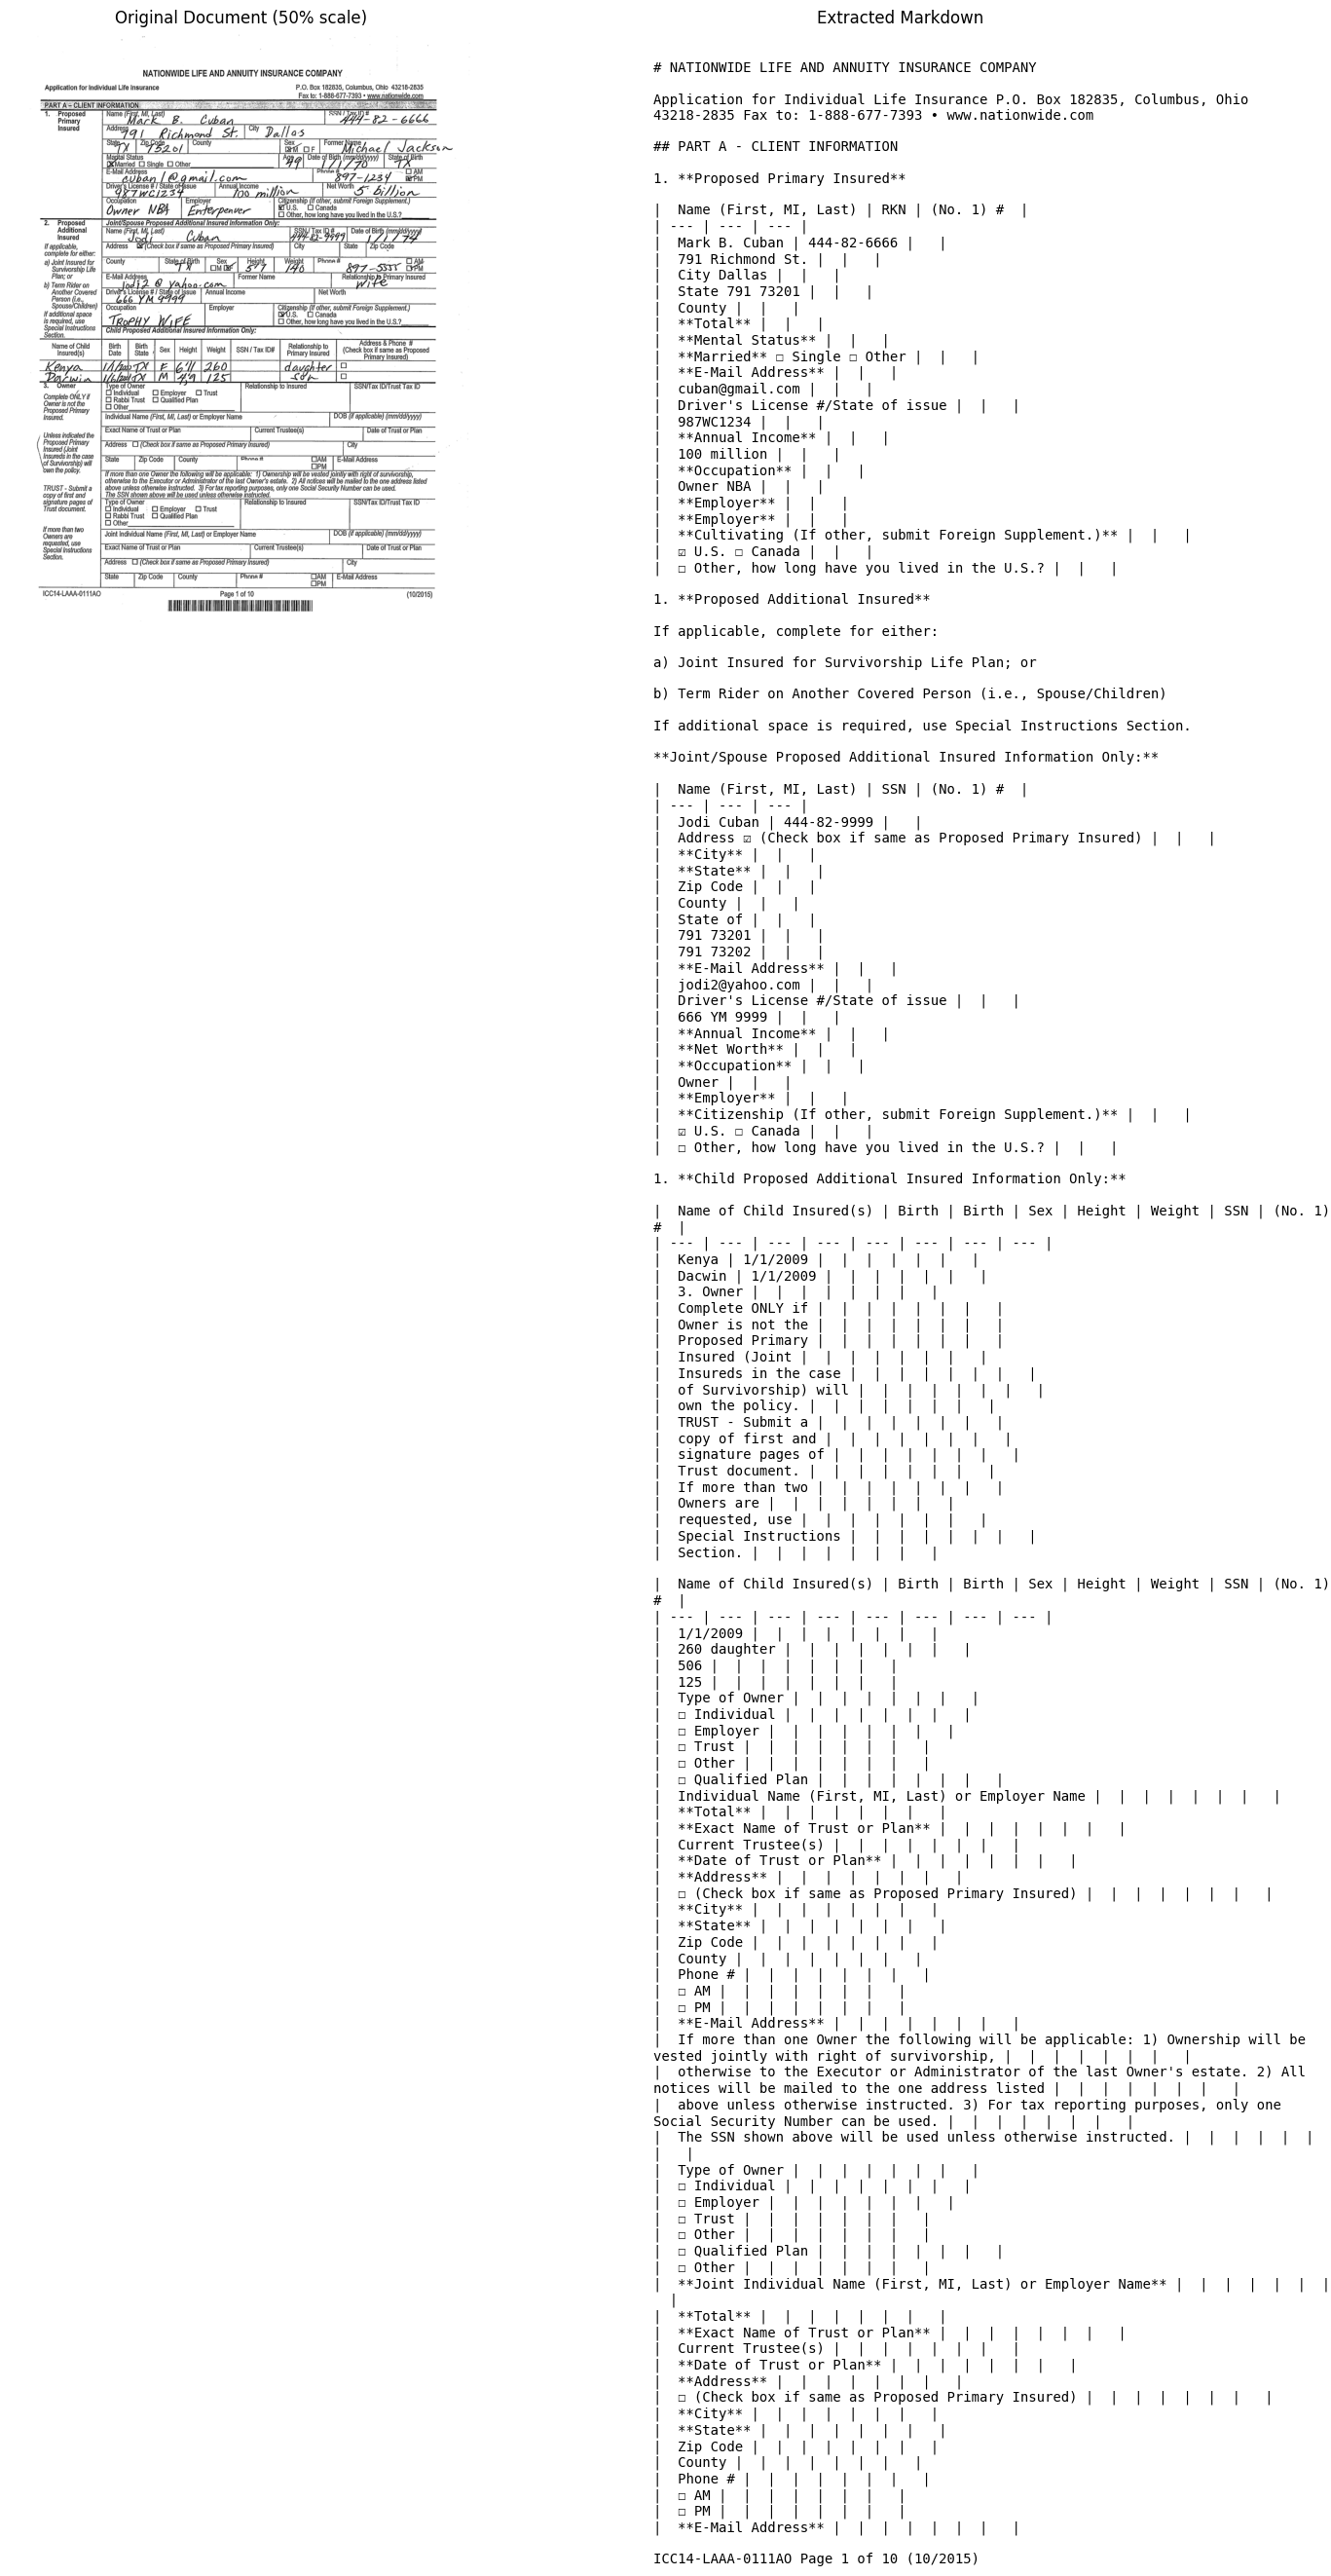

Extracted Markdown:
--------------------------------------------------
# NATIONWIDE LIFE AND ANNUITY INSURANCE COMPANY

Application for Individual Life Insurance P.O. Box 182835, Columbus, Ohio 43218-2835 Fax to: 1-888-677-7393 • www.nationwide.com

## PART A - CLIENT INFORMATION

1. **Proposed Primary Insured**

|  Name (First, MI, Last) | RKN | (No. 1) #  |
| --- | --- | --- |
|  Mark B. Cuban | 444-82-6666 |   |
|  791 Richmond St. |  |   |
|  City Dallas |  |   |
|  State 791 73201 |  |   |
|  County |  |   |
|  **Total** |  |   |
|  **Mental Status** |  |   |
|  **Married** ☐ Single ☐ Other |  |   |
|  **E-Mail Address** |  |   |
|  cuban@gmail.com |  |   |
|  Driver's License #/State of issue |  |   |
|  987WC1234 |  |   |
|  **Annual Income** |  |   |
|  100 million |  |   |
|  **Occupation** |  |   |
|  Owner NBA |  |   |
|  **Employer** |  |   |
|  **Employer** |  |   |
|  **Cultivating (If other, submit Foreign Supplement.)** |  |   |
|  ☑ U.S. ☐ Canada |  |   |
|  ☐ Other, h

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and resize the image to 50% scale
original_image = Image.open(sample_file_path)
width, height = original_image.size
resized_image = original_image.resize((width // 2, height // 2))

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Display the resized image on the left
ax1.imshow(resized_image)
ax1.set_title("Original Document (50% scale)")
ax1.axis('off')

# Display the markdown text on the right
markdown_text = ocr_result['pages'][0]['markdown']
ax2.text(0.05, 0.95, markdown_text, transform=ax2.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace', wrap=True)
ax2.set_title("Extracted Markdown")
ax2.axis('off')

plt.tight_layout()
plt.show()

# Also print the markdown for easy copying
print("Extracted Markdown:")
print("-" * 50)
print(ocr_result['pages'][0]['markdown'])

## 7. (Optional) Visualise bounding boxes

If the service returns `bbox` information alongside an inline image (via `include_image_base64`),
the cell below overlays the boxes on top of the image. Update the keys if your payload nests
the annotations differently.

In [25]:
import io
from PIL import Image, ImageDraw

image_base64 = None
if isinstance(ocr_result, dict):
    image_base64 = ocr_result.get("image_base64") or ocr_result.get("image")

if not image_base64:
    print("No base64 image found in the response. Ensure include_image_base64=True if you need a visualisation.")
else:
    if "," in image_base64:
        _, b64_data = image_base64.split(",", 1)
    else:
        b64_data = image_base64

    image_bytes = base64.b64decode(b64_data)
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    draw = ImageDraw.Draw(image)

    def draw_boxes(candidate):
        if isinstance(candidate, dict):
            if {"bbox", "text"}.issubset(candidate.keys()):
                bbox = candidate["bbox"]
                if isinstance(bbox, (list, tuple)) and len(bbox) == 4:
                    draw.rectangle(bbox, outline="red", width=2)
            for value in candidate.values():
                draw_boxes(value)
        elif isinstance(candidate, list):
            for item in candidate:
                draw_boxes(item)

    draw_boxes(ocr_result)
    display(image)


No base64 image found in the response. Ensure include_image_base64=True if you need a visualisation.


In [26]:
ocr_result

{'pages': [{'index': 0,
   'images': [],
   'markdown': "1. Customer Information\n2. Owner Type: [x] Individual [ ] Entity (e.g., trust/corporation)\nFor an entity, fill out the applicable fields only.\n3. Owner/Joint Owner Information:\nOwner Name: Aaron Rodgers\nDate of Birth: 2/16/81\nJoint Owner's Name: ________________________________ Date of Birth: ________________________________ (Blank for entity)\n4. Employment Status: [x] Employed [ ] Self-Employed [ ] Retired [ ] Not Employed\nName of Business (if applicable): Football\nOccupation or Nature of Business if self-employed (if applicable): Quarter back\n5. Nationwide Product Information\nSee product disclosures for details. For state specific questions, please contact us at 800-321-6064.\n6. Premium Amount: $ 1,000,000.00\n7. Surrender Charge Details:\nSurrender Charge Period Length: 9 years\nYear 1 Surrender Charge: 8.75 %\n8. Riders (fees and benefits):\n[ ] Enhanced Death Benefit [x] Living Benefit [ ] No Rider\nIf Yes, Rider